# Background

- deep learning ?
- framework
- bedanya

# Data

Let us start our neural network experience using `torch` in R by first preparing the dataset. You will use `Digit Recognizer (MNIST)` dataset which can be downloaded on [the following page](https://www.kaggle.com/c/digit-recognizer/data). Data to download are `train.csv` as train data and `test.csv` as test data. Both of the data store digit images measuring 28 x 28 pixels for 10 different categories.


# Installation

Please ensure you have installed the following package (`pandas`, `NumPy`, `Matplotlib`, and `Torch`). Here is the short instruction on how to create a new Conda environment with those package inside it.

1. Open the terminal or anaconda command prompt

   <img src="assets/terminal.PNG" width="500"/>

2. Create new conda environment by running the following command.

   `conda create -n <env_name> python=3.7`

3. Active the conda environment by running the following command.

   `conda activate <env_name>`

4. Install the pandas, Numpy, matplotlib package.

   `pip install pandas numpy matplotlib`


5. Install the torch package into the environment.

   `pip3 install torch torchvision torchaudio`
 
For more details you can visit [PyTorch setup](https://pytorch.org/get-started/locally/)

# Libraries

We will need to use `pip install &lt;package_name&gt;` to install any packages that are not already downloaded onto your machine. Then, you can load the package into your workspace using the `import`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.style.use('seaborn')
torch.manual_seed(123)

# Load Data

## Working with Images

In this project, we'll use our existing knowledge of PyTorch and Neural Network to solve a problem: **image classification**. We'll use famous [**MNIST Handwritten Digits Data**](https://www.kaggle.com/c/digit-recognizer/data) as our training dataset. It is consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample image from dataset: ![mnist](https://i.imgur.com/CAYnuo1.jpeg)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. We'll use the **`torch.tensor()`** to convert images into PyTorch tensors.

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, file_path):
        # read data
        df = pd.read_csv(file_path)
        
        target_col = 'label'
        self.label_exist = target_col in df.columns

        if self.label_exist:
            # split feature-target
            X = df.drop(columns=target_col).values
            y = df[target_col].values
            
            # convert numpy array to tensor
            self.y = torch.tensor(y)
        else:
            X = df.values
        
        self.X = torch.tensor(X, dtype=torch.float32)

        # scaling
        self.X /= 255

    # for iteration
    def __getitem__(self, idx):
        if self.label_exist:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]
    
    # to check num of observations
    def __len__(self):
        return self.X.size()[0]

In [ ]:
# load data set
mnist_data = MNISTDataset("mnist/train.csv")
print(mnist_data.X.size())

torch.Size([42000, 784])


In [ ]:
# global var
SPLIT_PROP = 0.8
BATCH_SIZE = 16

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

- **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
- **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
- **Test set** - used to compare different models or approaches and report the model's final accuracy.


In the MNIST dataset, there are 42,000 training images and 784 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 42,000 images into training, validation, and test datasets. Let's set aside 42,000 randomly chosen images for validation. We can do this using the **`random_split`** method from PyTorch.



In [ ]:
# train-val-test split
train_val_size = int(SPLIT_PROP * len(mnist_data))
test_size = len(mnist_data) - train_val_size

train_size = int(SPLIT_PROP * train_val_size)
val_size = train_val_size - train_size

train_mnist, val_mnist, test_mnist = random_split(mnist_data, [train_size, val_size, test_size])
print(len(train_mnist))
print(len(val_mnist))
print(len(test_mnist))

26880
6720
8400


It's essential to choose a random sample for creating a validation and test set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 16.

In [ ]:
train_loader = DataLoader(train_mnist, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_mnist, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1680
420
525


We set **`shuffle=True`** for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process.

# Visualize Data

The distribution of our class labels do seem to be spread out quite evenly. So, we need to check the distribution of digits in training, validation and test sample.

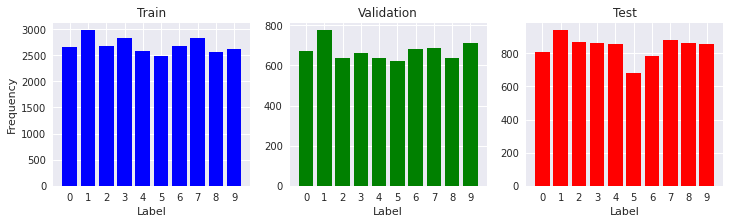

In [ ]:
# viz target prop
train_prop = mnist_data.y[train_mnist.indices].bincount()
val_prop = mnist_data.y[val_mnist.indices].bincount()
test_prop = mnist_data.y[test_mnist.indices].bincount()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, prop, title, col in zip(axes, [train_prop, val_prop, test_prop], ['Train', 'Validation', 'Test'], 'bgr'):
    class_target = range(0, 10)
    ax.bar(class_target, prop, color=col)
    ax.set_title(title)
    ax.set_xticks(class_target)
    ax.set_xlabel("Label")

axes[0].set_ylabel("Frequency")
plt.show()

Let's look at a couple if images from dataset:

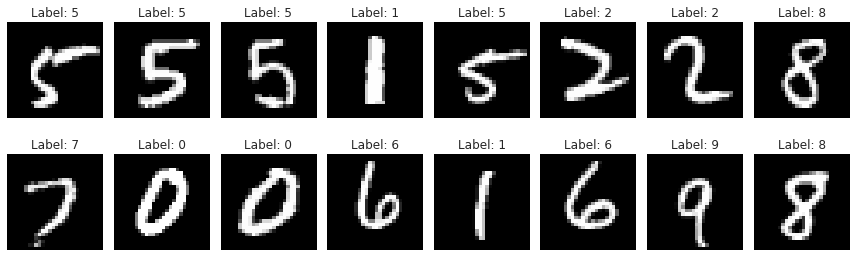

In [ ]:
images, labels = next(iter(train_loader))
images = images.reshape((train_loader.batch_size, 28, 28))

fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f'Label: {int(label)}')
plt.tight_layout()

# Define Model Architecture

We'll create neural network with two layers: a hidden layer and output layer. Additionally, we'll use an activation function between two layers. 

Let's create a **`nn.Sequential`** object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 128 and 64. The number can be increased or decreased to change the learning capacity of the model.

In [ ]:
# Sequential, Keras style

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size) # logit score
    )
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

The image vector of size 784 are transformed into intermediate output vector of length 128 then 64 by performing a matrix multiplication of inputs matrix.

Thus, input and layer1 outputs have linear relationship, i.e., each element of layer outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

![layers](https://i.imgur.com/inXsLuq.png)

Next, we'll use the **Rectified Linear Unit (ReLU)** function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:
![relu](https://i.imgur.com/yijV4xF.png)

We refer to ReLU as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

The output layer to convert vectors of length `hidden_sizes` in relu outputs into vector of length 10, which is the desired output of our model (since there are 10 target labels)

The output, contains a batch of vectors of size 10. We can now use this output to compute te loss using **`nn.CrossEntropyLoss()`**. Create an optimizer using **`torch.optim.Adam()`** using learning rate (`lr=0.001`).

In [ ]:
# specify loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (Adam) and learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the Model

Using pytorch, we have to manually loop the data per epoch to **train the model**. Here are the training loop for one epoch:

1. Clear gradients of all optimized variables from `optimizer`
2. Forward pass: compute predicted output by passing input data to the `model`
3. Calculate the loss based on specified `criterion`
4. Backward pass: compute gradient of the loss with respect to `model` parameters
5. Perform parameter update using `optimizer` algorithm
6. Accumulate training loss and accuracy

Inside the training loop, we also **validate the model** by performing the following steps:

1. Forward pass: compute predicted output by passing input data to the `model`
2. Calculate the loss based on specified `criterion`
3. Accumulate validation loss and accuracy

Special notes:

- If you use `Dropout` or `BatchNorm` layer, don't forget to use `model.train()` when training the model and `model.eval()` when validating/testing the model so that the layer behaves accordingly.
- Don't forget to set `torch.no_grad()` before validating the model to disable the gradient calculation since we are not updating the parameters.

But first let's us define `evaluate_accuracy` to calculate accuracy given the predicted `logits` and `y_true` actual label.

In [ ]:
def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)
    
    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    return acc * 100

Define training loop with the following parameters:

- `model`: untrained model
- `train_loader`: data train of a `DataLoader` object
- `val_loader`: data validation of a `DataLoader` object
- `criterion`: loss function to be optimized
- `optimizer`: optimization algorithm to used on the `model` parameters
- `n_epochs`: number of training epochs
- `model_file_name`: file name of serialized model. During the training loop, model with the lowest validation loss will be saved as a serialized model with `.pt` extension.

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        }
    }

    # initialize tracker for minimum validation loss
    val_loss_min = np.Inf

    # loop per epoch
    for epoch in range(n_epochs):
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0
        
        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each data
        for data, target in train_loader:
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)
            
        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each data
            for data, target in val_loader:
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)
            
        ####################   
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['acc']['train'].append(train_acc)
        history['acc']['val'].append(val_acc)
        
        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')
        
        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            torch.save(model.state_dict(), model_file_name)
            val_loss_min = val_loss

        print()

    # return model performance results per epoch
    return history

In [ ]:
history = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=20)

with open('history.pickle', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 001 | Train Loss: 0.35883 | Val Loss: 0.20376 | Train Acc: 89.62 | Val Acc: 93.79
Validation loss decreased (inf --> 0.20376)  Saving model to model.pt...

Epoch 002 | Train Loss: 0.15089 | Val Loss: 0.16123 | Train Acc: 95.35 | Val Acc: 95.07
Validation loss decreased (0.20376 --> 0.16123)  Saving model to model.pt...

Epoch 003 | Train Loss: 0.10185 | Val Loss: 0.12946 | Train Acc: 96.93 | Val Acc: 95.89
Validation loss decreased (0.16123 --> 0.12946)  Saving model to model.pt...

Epoch 004 | Train Loss: 0.07460 | Val Loss: 0.14482 | Train Acc: 97.63 | Val Acc: 95.64

Epoch 005 | Train Loss: 0.05526 | Val Loss: 0.12973 | Train Acc: 98.21 | Val Acc: 96.35

Epoch 006 | Train Loss: 0.04527 | Val Loss: 0.12478 | Train Acc: 98.54 | Val Acc: 96.56
Validation loss decreased (0.12946 --> 0.12478)  Saving model to model.pt...

Epoch 007 | Train Loss: 0.03887 | Val Loss: 0.11851 | Train Acc: 98.80 | Val Acc: 97.02
Validation loss decreased (0.12478 --> 0.11851)  Saving model to model.pt.

Visualize the loss and accuracy from `history` to see whether the model is overfitting, underfitting, or a good fit.

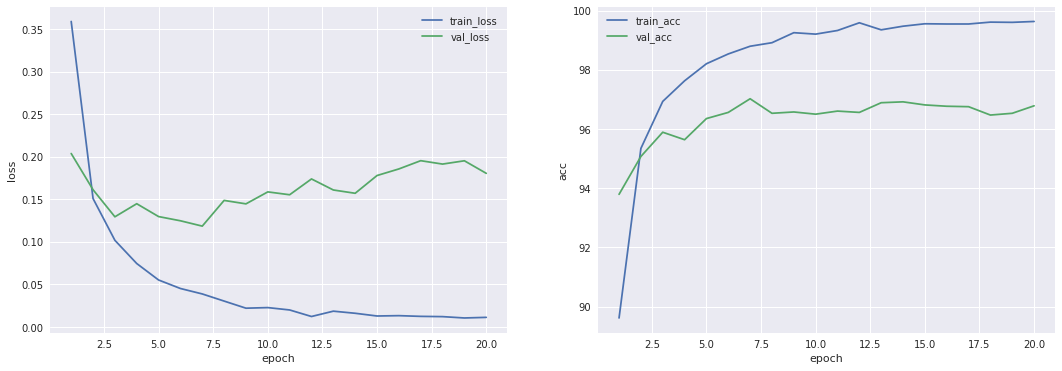

In [ ]:
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)

epoch_list = range(1, history['n_epochs']+1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
for ax, metric in zip(axes, ['loss', 'acc']):
    ax.plot(epoch_list, history[metric]['train'], label=f"train_{metric}")
    ax.plot(epoch_list, history[metric]['val'], label=f"val_{metric}")
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    ax.legend()

From the visualization, we can deduct that the model is a good fit since the difference of model performance on training and validation is not too much different.

# Test the Model

In this section, we are going to test the model performance by using confusion matrix. Here are the steps:

1. Forward pass: compute predicted output by passing input data to the **trained** `model`
2. Get predicted label by retrieve index with the largest logit value per observation
3. Append actual and predicted label to `y_test` and `y_pred` respectively

In [ ]:
# load the best model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
y_test = []
y_pred = []

# disable gradient calculation
with torch.no_grad():
    # prepare model for evaluation
    model.eval()

    # loop for each data
    for data, target in test_loader:
        # STEP 1: forward pass
        output = model(data)
        # STEP 2: get predicted label
        _, label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += target.numpy().tolist()
        y_pred += label.numpy().tolist()

Create a confusion matrix and classification report by using `sklearn` to know the model performance on test data.

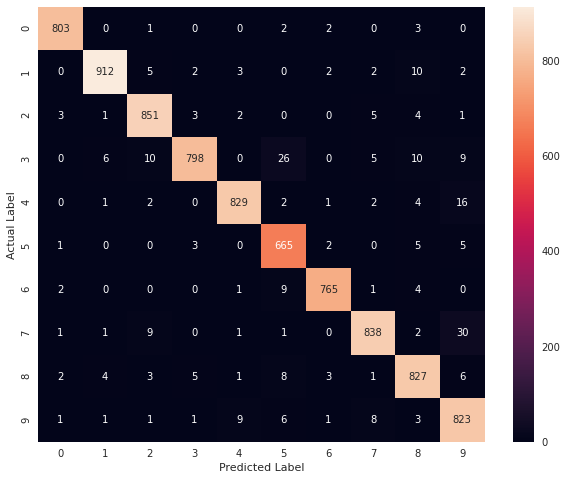

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       811
           1       0.98      0.97      0.98       938
           2       0.96      0.98      0.97       870
           3       0.98      0.92      0.95       864
           4       0.98      0.97      0.97       857
           5       0.92      0.98      0.95       681
           6       0.99      0.98      0.98       782
           7       0.97      0.95      0.96       883
           8       0.95      0.96      0.95       860
           9       0.92      0.96      0.94       854

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



Eventually, the model achieves 97% accuracy and other metrics reach >= 92% on unseen data.

# Predict the Unlabeled Data

In this last section, we use the trained model to predict the unlabeled data from `test.csv`, which only consists 784 columns of pixel.

In [ ]:
# load test.csv
mnist_data_unlabeled = MNISTDataset("mnist/test.csv")
unlabeled_loader = DataLoader(mnist_data_unlabeled, batch_size=1, shuffle=True)

print(mnist_data_unlabeled.X.size())

torch.Size([28000, 784])


Each image is feeded into the model and `F.softmax` activation function will be applied on the output value to convert logit scores to probability. The visualization tells us the predicted probability given an image, and then class with the highest probability will be the final predicted label of that image.

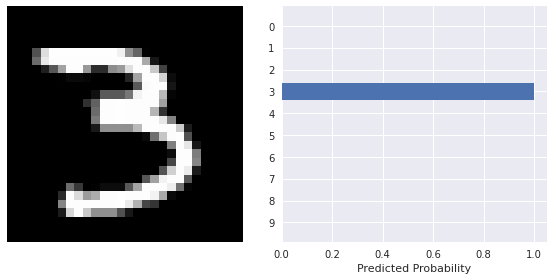

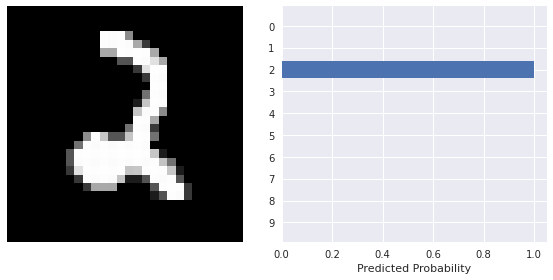

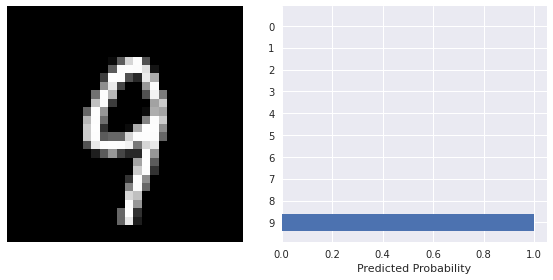

In [ ]:
# loop data
for idx in range(3):
    # get image from loader
    image = next(iter(unlabeled_loader))
    image = image.reshape((28, 28))

    ##############   
    # prediction #
    ##############

    with torch.no_grad():
        # forward pass
        output = model(image.reshape(1,-1))
        # calculate probability
        prob = F.softmax(output, dim=1)

    #################   
    # visualization #
    #################

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # digit image
    axes[0].imshow(image, cmap="gray")
    axes[0].axis("off")

    # predicted probability
    axes[1].barh(range(0,10), prob.reshape(-1))
    axes[1].invert_yaxis()
    axes[1].set_yticks(range(0,10))
    axes[1].set_xlabel("Predicted Probability")

    plt.tight_layout()
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1cee4b0-d311-47d3-8bc6-ab6ee3455f30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>